## What is the Airbnb distribution and pricing around the city of Ottawa, ON, Canada?

Airbnb making their hosting data publicly available allows us to see the distribution of short term rental units across a cityscape.  We can use this vision to get a sense of hotspots in the city and where pricing reflects commodities and attractions.  This analysis was inspired by [A Deep Dive into Geospatial Analysis](https://nbviewer.jupyter.org/github/ResidentMario/boston-airbnb-geo/blob/master/notebooks/boston-airbnb-geo.ipynb).

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import seaborn as sns
import numpy as np
import re
import os
if not os.path.exists('images'):
    os.makedirs('images')
%matplotlib inline

We'll be working with Airbnb listings data from Ottawa, ON, Canada.  More specifically we have the data files:
* `listings.csv` info about each listing including descriptions, host details, unit details location, etc.
* `neighbourhoods.geojson` census neighbourhood geometries of Ottawa to map defined neighbourhoods

In [2]:
listings = pd.read_csv("./listings.csv")
ottawa = gpd.read_file("./neighbourhoods.geojson")

In [3]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,34220,https://www.airbnb.com/rooms/34220,20201220034156,2020-12-20,Room available,<b>The space</b><br />This room is part of a t...,NaN,https://a0.muscache.com/pictures/192935/3bf5a8...,147438,https://www.airbnb.com/users/show/147438,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


In [4]:
ottawa.head(2)

,neighbourhood,neighbourhood_group,geometry
0,Rideau-Goulbourn,None,"MULTIPOLYGON Z (((-75.79872 45.29269 0.00000, ..."
1,Rideau-Vanier,None,"MULTIPOLYGON Z (((-75.65350 45.44392 0.00000, ..."


In [5]:
print(listings.shape)
print(ottawa.shape)

(2693, 74)
(23, 3)


First we check to see if the coordinate reference system (CRS).  We want to make sure we're using EPSG:4326 which is a standard coordinate reference system for geo data.

In [6]:
ottawa.crs

{'init': 'epsg:4326'}

Lets take an initial look at the Airbnb distributions across the city of Ottawa.

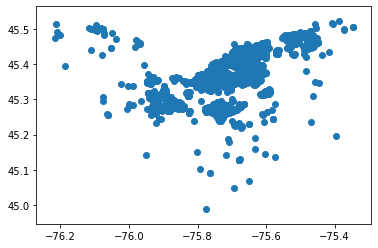

In [7]:
plt.scatter(listings['longitude'], listings['latitude']);

We can see a few clusters of units, with the most near the top center right.  Let's take a look at the census tracts (neighbourhoods) in Ottawa to get a sense of where these hot spots are.

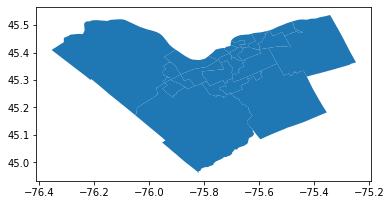

In [8]:
ottawa.plot();

Above we can see an even distribution along the north part of Airbnb units along the north part of the city, which consists mainly of the downtown core and some other trendy areas but we'd like a clear picture of unit denisty and pricing distribution.

For this analysis we're only really interested in some geospatial, unit type, and pricing features so we'll drop everything else from listings.

In [9]:
columns_with_geo_data = ['neighbourhood_cleansed', 'latitude', 'longitude',]
columns_with_unit_data = ['property_type', 'room_type',]
columns_with_pricing_data = ['price']
listings = listings[columns_with_geo_data + columns_with_unit_data + columns_with_pricing_data]

In [10]:
ottawa.drop(['neighbourhood_group'], inplace=True, axis=1)
ottawa.head()

,neighbourhood,geometry
0,Rideau-Goulbourn,"MULTIPOLYGON Z (((-75.79872 45.29269 0.00000, ..."
1,Rideau-Vanier,"MULTIPOLYGON Z (((-75.65350 45.44392 0.00000, ..."
2,Orleans,"MULTIPOLYGON Z (((-75.50771 45.46143 0.00000, ..."
3,West Carleton-March,"MULTIPOLYGON Z (((-76.08706 45.51833 0.00000, ..."
4,Cumberland,"MULTIPOLYGON Z (((-75.32030 45.50050 0.00000, ..."


We want to get a set of representative coordinates for each neighbourhood to plot labels on our maps later.

In [11]:
ottawa['coords'] = ottawa['geometry'].apply(lambda x: x.representative_point().coords[:])
ottawa['area'] = ottawa['geometry'].apply(lambda x: x.area)
ottawa['coords'] = [coords[0] for coords in ottawa['coords']]
ottawa.head(2)

,neighbourhood,geometry,coords,area
0,Rideau-Goulbourn,"MULTIPOLYGON Z (((-75.79872 45.29269 0.00000, ...","(-75.81371284161762, 45.126986)",0.084273
1,Rideau-Vanier,"MULTIPOLYGON Z (((-75.65350 45.44392 0.00000, ...","(-75.67639572674302, 45.431203499999995)",0.000914


We want to get a sense of the null rates in each column so we visually inspect.

In [12]:
total_listings = listings.shape[0]
listings.isna().sum()/total_listings

neighbourhood_cleansed    0.0
latitude                  0.0
longitude                 0.0
property_type             0.0
room_type                 0.0
price                     0.0
dtype: float64

We wish to drop the rows with missing values in either price, latitude, or longitude since these are the key factors we're using in the analysis and missing data is useless in either field.

In [13]:
listings.dropna(subset=['price', 'latitude', 'longitude'], axis=0, how='any')
listings.isna().sum()/total_listings

neighbourhood_cleansed    0.0
latitude                  0.0
longitude                 0.0
property_type             0.0
room_type                 0.0
price                     0.0
dtype: float64

Our `listings` dataframe contains two geospatial fields, latitude & longitude.  We want to convert this representation to true geometries (Points) so that we can mesh with the `ottawa` dataframe geometries.

In [14]:
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))
listings['geometry'].head()

0    POINT (-75.67900 45.40924)
1    POINT (-75.74679 45.40159)
2    POINT (-75.80314 45.35900)
3    POINT (-75.69941 45.40248)
4    POINT (-75.75496 45.38972)
Name: geometry, dtype: geometry

Next we want to convert the price into a numerical datatype for analysis for analysis.

In [15]:
listings['price'] = listings['price'].apply(lambda value: re.sub(r'\$|,|%', '', str(value))).astype(float)
listings.price.head(2)

0    202.0
1     65.0
Name: price, dtype: float64

We'd like to analyze the types of units, but we're only interested in the main types for this exploratory analysis.  Everything else we can classify as 'Other'.

In [16]:
def rename_property_types(el):
    '''
    INPUT
    el - an element (string) to be grouped by name
    
    OUTPUT
    string containing a new group name for the element
    
    Groups elements based on the content in its string and returns the group name.
    '''
    if 'Private room' in el:
        return 'Private room'
    elif el in ['Entire apartment', 'Entire condominium', 'Entire loft']:
        return 'Entire Condo/Apt'
    elif el in ['Entire house', 'Entire bungalow', 'Entire Cottage', 'Entire Cabin', 'Entire Chalet']:
        return 'Entire House'
    else:
        return 'Other'

listings['property_type'] = listings['property_type'].apply(rename_property_types)
listings['property_type'].value_counts()

Private room        1026
Entire Condo/Apt     875
Entire House         444
Other                348
Name: property_type, dtype: int64

We want to blend the point location of each Airbnb unit in `listings` with each geometry in `ottawa`.  Here we will assign the coordinate Point above into a census tract from the Ottawa dataframe by search for which points actually lie in the neighbourhood area.  We append the results to the `listings` dataframe.

In [17]:
def assign_census_tract(bnb_point):
    # checks if point is located in neighbourhood geometry
    bools = [geom.contains(bnb_point['geometry']) for geom in ottawa['geometry']] 
    if True in bools:
        # return neighbourhood name that contains the point
        return ottawa.iloc[bools.index(True)]['neighbourhood']
    else:
        return np.nan

In [18]:
listings['census_tract'] = listings.apply(assign_census_tract, axis='columns')
listings.census_tract.value_counts()

Rideau-Vanier              541
Somerset                   387
Kitchissippi               189
Capital                    185
Rideau-Rockcliffe          133
River                      128
Kanata North               102
College                    100
Alta Vista                 100
Gloucester-Southgate        86
Bay                         83
Gloucester-South Nepean     76
Knoxdale-Merivale           70
Beacon Hill-Cyrville        66
Cumberland                  65
Barrhaven                   57
Orleans                     57
Kanata South                57
Stittsville-Kanata West     55
West Carleton-March         47
Rideau-Goulbourn            45
Innes                       37
Osgoode                     25
Name: census_tract, dtype: int64

Let's map the number of units by census tract in `listings` to the `ottawa` geodataframe.

In [19]:
ottawa['BNBCount'] = ottawa['neighbourhood'].map(listings['census_tract'].value_counts())
ottawa.head()

,neighbourhood,geometry,coords,area,BNBCount
0,Rideau-Goulbourn,"MULTIPOLYGON Z (((-75.79872 45.29269 0.00000, ...","(-75.81371284161762, 45.126986)",0.084273,45
1,Rideau-Vanier,"MULTIPOLYGON Z (((-75.65350 45.44392 0.00000, ...","(-75.67639572674302, 45.431203499999995)",0.000914,541
2,Orleans,"MULTIPOLYGON Z (((-75.50771 45.46143 0.00000, ...","(-75.50824723305084, 45.486971)",0.002922,57
3,West Carleton-March,"MULTIPOLYGON Z (((-76.08706 45.51833 0.00000, ...","(-76.11172536011694, 45.347756000000004)",0.087956,47
4,Cumberland,"MULTIPOLYGON Z (((-75.32030 45.50050 0.00000, ...","(-75.38271071818716, 45.424179)",0.043663,65


Let's plot the number of BNB's per census tract in a choropleth to get a sense of populus neighbourhoods.

In [20]:
def plot_choropleth(col, df=ottawa, k=8, labels=False, min_label_area=0.01):
    '''
    Plots a choropleth map based on an input column.
    
    INPUT
    col - the column to be plotted
    df - the dataframe used to plot the choropleth
    k - number of quantiles in plot
    labels - boolean showing if labels are to be included on plot
    min_label_area - minimum polygon area threshold for adding a label
    
    OUTPUT
    choropleth plot
    
    Takes a dataframe with geosptatial polygona data and plots a choropleth highlighting the intensity based on col.
    '''
    f = plt.figure(figsize=(10, 10))
    ax = f.gca()
    kw = dict(column=col, k=k, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.25)
    df.plot(scheme='Quantiles', ax=ax, **kw)
    if labels:
        for idx, row in df.iterrows():
            if row.area > min_label_area:
                plt.annotate(s=row['neighbourhood'], xy=row['coords'],
                         horizontalalignment='center')
    ax.set_axis_off()
    plt.savefig('./images/'+col+'.png', dpi=300, bbox_inches='tight', pad_inches=0)

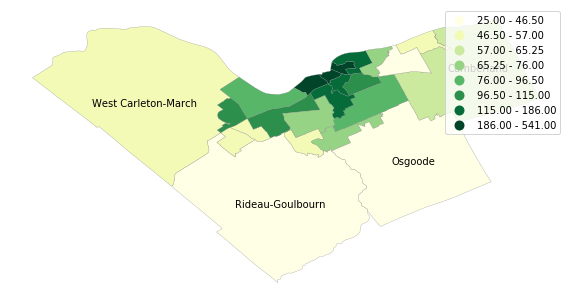

In [21]:
plot_choropleth('BNBCount',labels=True)

The darker the shadings, the more populus the census tract.  The problem with this map is that it doesn't take into account the size of the census tracts. We need to explore the airbnb densities (Units/km^2) to get a clearer sense of distribution throughout the city.

In [22]:
def geometric_density(col, df=ottawa):
    '''
    INPUT
    col - column input containing numerical data to which we will determine its density based on geospatial polygon area 
    df - dataframe containing geospatial polygons to which we will calculate the area in km^2
    
    OUTPUT
    inplace transformation of df adding a new column with the name col+'Density' that holds the density of col
    
    Takes col which is grouped by a geospatial area reference and computes the division of the value in col with the
    area of its geometry in km^2.
    '''
    df[col+'Density'] = (df[col] / df['geometry']
                        .to_crs({'init': 'epsg:3395'})\
                       .map(lambda p: p.area / 10**6))\
                       .fillna(0)

In [23]:
geometric_density('BNBCount')

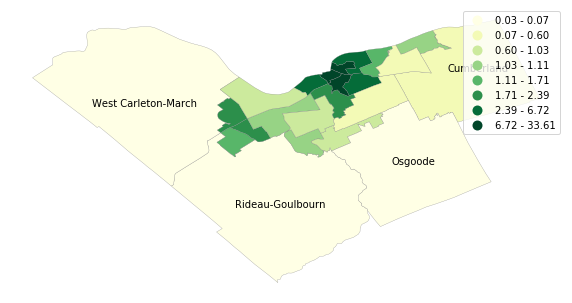

In [24]:
plot_choropleth('BNBCountDensity',labels=True)

Below is the percentage of total Airbnbs per neighbourhood.

In [25]:
ottawa['BNBPercent'] = round(100 * ottawa['BNBCount'] / ottawa['BNBCount'].sum(), 1)
ottawa[['neighbourhood', 'BNBPercent']].sort_values('BNBPercent', ascending=False)

,neighbourhood,BNBPercent
1,Rideau-Vanier,20.1
7,Somerset,14.4
16,Kitchissippi,7.0
19,Capital,6.9
20,Rideau-Rockcliffe,4.9
17,River,4.8
10,Kanata North,3.8
13,College,3.7
6,Alta Vista,3.7
14,Gloucester-Southgate,3.2


This gives us a clear picture into the size and the distribution of the Airbnb's according to density.  It's noticaeble that the largest cluster is in and near the downtown core.  It's also expected that as we distance ourselves from the core the gradient decreases in unit density.  We'd like to next investigate average price per neighbourhood.

In [26]:
def average_pricing_by_property_type(col, filter_by=None, df=ottawa, listings=listings, threshold=3):
    '''
    INPUT
    col - dataframe column to determine the average price
    filter_by - property type (string) in which to filter the df by
    df - dataframe to apply counts and AvgPrice calculations to
    listings - dataframe containing original Airbnb listings with property type and census_tract as features
    threshold - the minimum number of units needed to be considered in a grouping, if less than drop
    
    OUTPUT
    inplace transformation of df that contains new features, col+'Count' and col+'AvgPrice'
    
    Adds features to a dataframe that is grouped by neighbouhood that illustrate:
    1. the count of the total listings in that neighbourhood
    2. the sum of the price of all the listings in that neighbourhood divided by the count of all those listings
    Can be filtered by property type.
    '''
    if filter_by is not None:
        filtered_listings = listings[listings['property_type'] == filter_by]
    else:
        filtered_listings = listings
    df[col+'Count'] = df['neighbourhood'].map(filtered_listings['census_tract'].value_counts()).fillna(0)
    df.loc[(df[col+'Count'] < threshold), col+'Count'] = np.nan
    df[col+'AvgPrice'] = (df['neighbourhood'].map(filtered_listings.groupby('census_tract')['price'].sum()) / df[col+'Count']).fillna(0)
    df[col+'Count'].fillna(0, inplace=True)

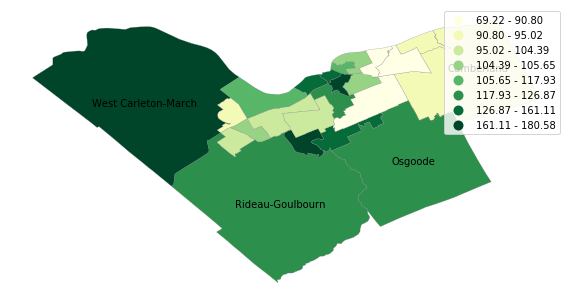

In [27]:
average_pricing_by_property_type('BNB')
plot_choropleth('BNBAvgPrice', labels=True)

It seems that the higher priced options lie on the outskirts of the city and in a neigbourhood south of downtown.  It's known that the neighbourhood south of downtown is a more affluent area so unit prices are probably higher.  On the outskirts of the city we're looking at cottage country, which is reasonable to see higher unit costs.  Let's do the same look but split between either Houses or Apartments/Condos to get a more representative sense of the distribution of average home price.

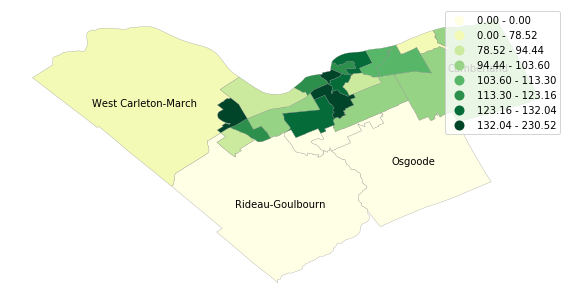

In [28]:
average_pricing_by_property_type('Condo', filter_by='Entire Condo/Apt')
plot_choropleth('CondoAvgPrice',labels=True)

It's not suprising to see that for apartment and condos the highest priced options are in the downtown/tourist core.  What is interesting is the influx of prices in the west end of the city and in the south end of the city.  Again, for the south end, the neighbourhood is affluent and close to a tourist hub for football and farmer's markets which can explain the price hike.  The NHL hockey stadium is infact located in the west end near to where the influx is, which can the higher condo/apartment prices.

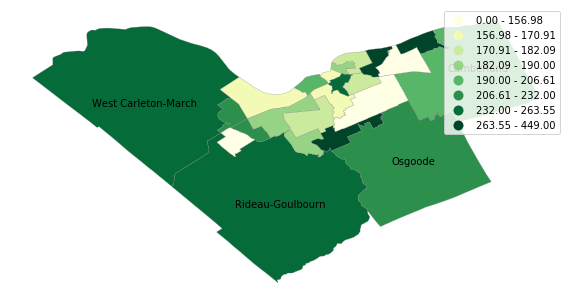

In [29]:
average_pricing_by_property_type('House',filter_by='Entire House')
plot_choropleth('HouseAvgPrice',labels=True)

For the housing Airbnb market it can be seen that the outskirts of the city are expensive, which is reasonable considering that it's cottage country.  There are some very expensive areas on the east side and the central south side.  Both of these areas are very affluent, big house, neighbourhoods and we can see that is reflected in the cost of the Airbnbs.